'''
*********
**USAGE**
*********
    Function Name: triple_sensitivity_plot
    Built-in Function:
        add_bar
        set_text
        plot_bar
    Usage by 'import' : from triple_plot import *
    
    ********
    **ARGS**
    ********
        names: list, -> y ticks labels
        value: list, -> for plotting bins
        pct_value: list =None, -> percentage value tags
        title: str = '', -> title for the hist
        dollar_ind: bool = False, -> dollar value tags
        color_schema: str = 'distinct', -> color schema (colormap,extra_contrast,distinct)
        width=0.05, -> width for the bin
        space=0.1, -> space between bins
        distinct_color_resolution=0.4, -> control the contrast degree between bins, only work for distinct mode 
        negative_color='white', -> color of the bins with a negative height
        difference_color='yellow', -> color of the part caused by severity or others
        stripe_negative_bar=True, -> put stripe on the negative bin
        figure_size=(24, 12), -> figure size
        shift_h = 'adjust', -> the distance between dollar and percentage tags
        see_or_not=False -> the show the process
'''

In [8]:
%matplotlib inline

In [9]:

import os
import sys
import datetime
import pandas as pd
import numpy as np
import itertools
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import copy
import time

def triple_sensitivity_plot(
        names: list,
        value: list,
        pct_value: list =None,
        title: str = '',
        dollar_ind: bool = False,
        color_schema: str = 'distinct',
        width=0.05,
        space=0.1,
        distinct_color_resolution=0.4,
        negative_color='white',
        difference_color='yellow',
        stripe_negative_bar=True,
        figure_size=(24, 12),
        shift_h = 'adjust',
        see_or_not=False):
    # input

    #    names = ['Base','SA-Macro1','SA-Macro2','SA-Macro3','SA-Macro4','SA']
    #    value = [8,12,15,19,40,40]

    mid = int((len(value) + 1) / 2)
    names = [names[0]] + ['+' + i for i in names[1:(mid - 1)]] + [names[mid - 1]] + ['+' + i for i in names[mid:-1]] + [names[-1]]
    # perpare for the bar chart data
    differ = np.diff(value).tolist()
    # change percentage
    change = value[-1] - value[0]
    ch_per = [round(d / change, 4) for d in differ][0:-1]
    # change value
    ch_value = [value[0]] + differ[0:mid - 2] + \
        [value[mid - 1]] + differ[mid - 1:-1] + [value[-1]]
    # number of bins
    posi = np.arange(len(value))

    # bars data : height
    height = ch_value  # this is for each bin
    bottom = [0] + np.cumsum(height[0:(mid - 2)]).tolist() + \
        [0] + np.cumsum(height[(mid - 1):-2]).tolist() + [0]
    left = [space + i * (width + space) for i in posi]

    # decompose into two parts: not stacked bar & stacked bar
    # original
    original_height = [height[0]]
    original_bottom = [0]
    original_left = [left[0]]
    original_value = ch_value[0]
    # individuals
    individuals_height = list(height[1:(mid - 1)]) + list(height[mid:-1])
    individuals_bottom = np.cumsum(
        height[0:(mid - 2)]).tolist() + np.cumsum(height[(mid - 1):-2]).tolist()
    individuals_left = list(left[1:(mid - 1)]) + list(left[mid:-1])
    individuals_value = list(ch_value[1:(mid - 1)]) + list(ch_value[mid:-1])
    # stacked bar:

    # mid
    mid_stacked_height = height[0:(mid - 1)]
    # to correct the difference caused by severity
    mid_stacked_height.append(value[mid - 1] - sum(mid_stacked_height))
    mid_stacked_bottom = bottom[0:(mid - 1)]
    # to correct for the difference caused by severity
    mid_stacked_bottom.append(sum(mid_stacked_height))
    mid_stacked_left = [left[mid - 1]] * len(mid_stacked_height)
    mid_stacked_value = ch_value[mid - 1]
    # right
    right_stacked_height = list(height[0:(mid - 1)]) + list(height[mid:-1])
    # correct difference
    right_stacked_height.append(value[-1] - sum(right_stacked_height))
    right_stacked_bottom = list(bottom[0:(mid - 1)]) + list(bottom[mid:-1])
    # correct difference
    right_stacked_bottom.append(sum(right_stacked_height))
    right_stacked_left = [left[-1]] * len(right_stacked_height)
    right_stacked_value = ch_value[-1]
    # pct_value
    if not pct_value:
        pct_value = [None] * len(value)
    else:
        # same as value
        pct_differ = np.diff(pct_value).tolist()
        pct_ch_value = [pct_value[0]] + pct_differ[0:mid - 2] + \
            [pct_value[mid - 1]] + pct_differ[mid - 1:-1] + [pct_value[-1]]
        original_pct_value = pct_value[0]
        individuals_pct_value = list(
            pct_ch_value[1:(mid - 1)]) + list(pct_ch_value[mid:-1])
        mid_stacked_pct_value = pct_value[mid - 1]
        right_stacked_pct_value = pct_value[-1]

    # personalized color
    # add the new color schema
    if color_schema == 'colormap':
        norm = Normalize(vmin=-min(value), vmax=max(value))
        color = cm.BuPu(norm(height))
    elif color_schema == 'extra_contrast':
        color_seg = np.linspace(0, 1.00, 12)
        color_pairs = color_seg.reshape((6, 2))
        color_pairs_num = int((len(names) - 3) / 2)
        color_select = color_pairs[0:(color_pairs_num)]
        color_dict = {i: j for i, j in zip(names[1:(mid - 1)], color_select)}
        color = [cm.Set2(0)] + cm.Paired([color_dict[i][0] for i in names[1:(mid - 1)]]).tolist() + [
            cm.Set2(0.5)] + cm.Paired([color_dict[i][1] for i in names[(mid):-1]]).tolist() + [cm.Set2(1)]
    elif color_schema == 'distinct':
        color_seg = np.linspace(distinct_color_resolution, 1, len(names) - 3)
        color_select = list(
            zip(color_seg[0:len(color_seg) // 2], color_seg[len(color_seg) // 2:]))
        color_dict = {i: j for i, j in zip(names[1:(mid - 1)], color_select)}
        color = [cm.Set2(0)] + cm.Blues([color_dict[i][0] for i in names[1:(mid - 1)]]).tolist() + [
            cm.Set2(0.5)] + cm.Blues([color_dict[i][1] for i in names[(mid):-1]]).tolist() + [cm.Set2(1)]
    else:
        raise ValueError('Color Schema not found!')
    # adjust for the color
    color = [i if j >= 0 else negative_color for i, j in zip(color, height)]
    # pick out colors
    # original
    original_color = [color[0]]
    # individual
    individuals_color = list(color[1:(mid - 1)]) + list(color[mid:-1])
    # mid_stacked
    mid_stacked_color = color[0:(mid - 1)]
    # right_stacked
    right_stacked_color = list([color[0]]) + individuals_color
#    #****************************#
#    print('*************************',len(right_stacked_color))
#    print('*************************',right_stacked_color)
#    
#    print('*************************',len(right_stacked_bottom))
#    print('*************************',right_stacked_bottom)
#    
#    
#    print('*************************',len(right_stacked_height))
#    print('*************************',right_stacked_height)
#    # make up adding lines data
    starter_x = np.asarray(left[0:-1]) + width
    starter_y = value[0:-1]
    end_x = [left[-1]] * len(starter_x)

    # Create figure: fig ->figure object; axs->subplot object
    fig, axs = plt.subplots(1, 1, figsize=figure_size)
    # set the margins of plots
    axs.set_xlim(space * 0.5, (space + width) * len(value) + space * 0.5)
    axs.set_ylim(0, max(value) * 1.1)

    if shift_h == 'adjust':
        shift_h = 0.028 * max(value)
    # original
    plot_bar(original_left, original_height, original_bottom,
             original_color, axs,original_value, original_pct_value,shift_h=shift_h,width=width, margin=True,see_or_not=see_or_not)
    plot_bar(individuals_left, individuals_height, individuals_bottom,
             individuals_color,axs, individuals_value, individuals_pct_value,shift_h=shift_h,width=width,see_or_not=see_or_not)
    plot_bar(mid_stacked_left, mid_stacked_height, mid_stacked_bottom,
             mid_stacked_color, axs,mid_stacked_value, mid_stacked_pct_value,shift_h=shift_h,width=width,margin=True,see_or_not=see_or_not)
    plot_bar(right_stacked_left[0:], right_stacked_height[0:], right_stacked_bottom,
             right_stacked_color, axs,right_stacked_value, right_stacked_pct_value,shift_h=shift_h,width=width,margin=True,see_or_not=see_or_not)
    # add reference line
    axs.hlines(starter_y, starter_x, end_x,
               linestyle='dashdot', color='pink')

    # labels control system
    axs.tick_params(
        axis='both',
        which='both',
        bottom='off',
        top='off',
        left='off',
        right='off',
        labelbottom='on',
        labelleft='off')
    axs.set_xticks(np.asarray(left) + width / 2)
    axs.set_xticklabels(names, fontsize=15, rotation=10)
    # Titles control
    axs.set_title(title, fontsize=20)
    # adjustment part
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    axs.axis('on')
    axs.grid(False)
    return fig

    

def add_bar(axs,alpha=1, linewidth=0.01, stripe_negative_bar=True, **kwargs):
    paras = {i:j for i,j in kwargs.items()}
    if stripe_negative_bar:
        if kwargs.get('height') < 0:
#            print('***********************************')
            return axs.bar(linewidth=linewidth, alpha=alpha,
                           hatch='X', linestyle='dashed', edgecolor='red',**paras)[0]
        else:
#            print('***********************************')
            edgecolor = kwargs.get("edgecolor")
            return axs.bar(edgecolor=edgecolor, linewidth=linewidth, alpha=alpha,**paras)[0]
    else:
        edgecolor = kwargs.get("edgecolor")
        return axs.bar(edgecolor=edgecolor, linewidth=linewidth, alpha=alpha,**paras)[0]


# text function to draw tags on bins
def set_text(bins, ax, value, margin=False,shift_h=0, dollar_ind=True):
    b = bins
    j = value
    if margin :
        if dollar_ind:
            j /= 1000000
            j = '{:,.0f}'.format(j)
            ax.text(b.get_x() + b.get_width() / 2, b.get_y() + b.get_height() + shift_h,
                    '$' + j + 'MM', ha='center', va='bottom', fontsize=12)
        else:
            ax.text(b.get_x() + b.get_width() / 2, b.get_y() + b.get_height() + shift_h,
                    '%.1f' % (j) + '%', ha='center', va='bottom', fontsize=12)
    else:
        if dollar_ind:
            pp = j
            j /= 1000000
            j = '{:,.0f}'.format(j)
            if pp >= 0:
                ax.text(b.get_x() + b.get_width() / 2, b.get_y() + b.get_height() + shift_h,
                        '+$' + j + 'MM', ha='center', va='bottom', fontsize=12)
            else:
                ax.text(b.get_x() + b.get_width() / 2, b.get_y() + b.get_height() + shift_h,
                        '-$' + j + 'MM', ha='center', va='bottom', color='red', fontsize=12)
        else:
            pp = j
            if pp >= 0:
                ax.text(b.get_x() + b.get_width() / 2, b.get_y() + b.get_height() + shift_h,
                        '+%.2f' % (j) + '%', ha='center', va='bottom', fontsize=12)
            else:
                ax.text(b.get_x() + b.get_width() / 2, b.get_y() + b.get_height() + shift_h,
                        '-%.2f' % (j) + '%', ha='center', va='bottom', color='red', fontsize=12)

# add bars
# individuals
def plot_bar(left, height, bottom, color, axs, value, pct_value,shift_h, width, margin=False, stripe_negative_bar=True, see_or_not=False):
    if not margin:
        for l, h, b, c, v, pct in zip(left, height, bottom, color, value, pct_value):
            per = add_bar(left=l,
                          height=h,
                          bottom=b,
                          width=width,
                          color=c,
                          axs=axs,
                          stripe_negative_bar=stripe_negative_bar)
            set_text(per, axs, v)
            if pct is not None:
                set_text(per, axs, pct, dollar_ind=False,
                         shift_h=shift_h)
            if see_or_not:
                print('SetBar')
    else:
#        print('**********',list(zip(left, height, bottom, color)))
#
#        print('ppppppppppp',left)
#        print('-----------',height)
#        print(';;;;;;;;;;;',bottom)
#        print('++++++++++',color)
        for l, h, b, c in zip(left, height, bottom, color):
#            print('****************sdadasdas******************')
            per = add_bar(left=l,
                          height=h,
                          bottom=b,
                          width=width,
                          color=c,
                          axs=axs,
                          stripe_negative_bar=stripe_negative_bar)
#            print('*******************'+str(type(per))+'*************************')
#            print('*******************',per,'*************************')
            if see_or_not:
                print('SetBar')
        set_text(per, axs, value,margin=True)
        if pct_value is not None:
            set_text(per, axs, pct_value,margin=True, dollar_ind=False,shift_h=shift_h)



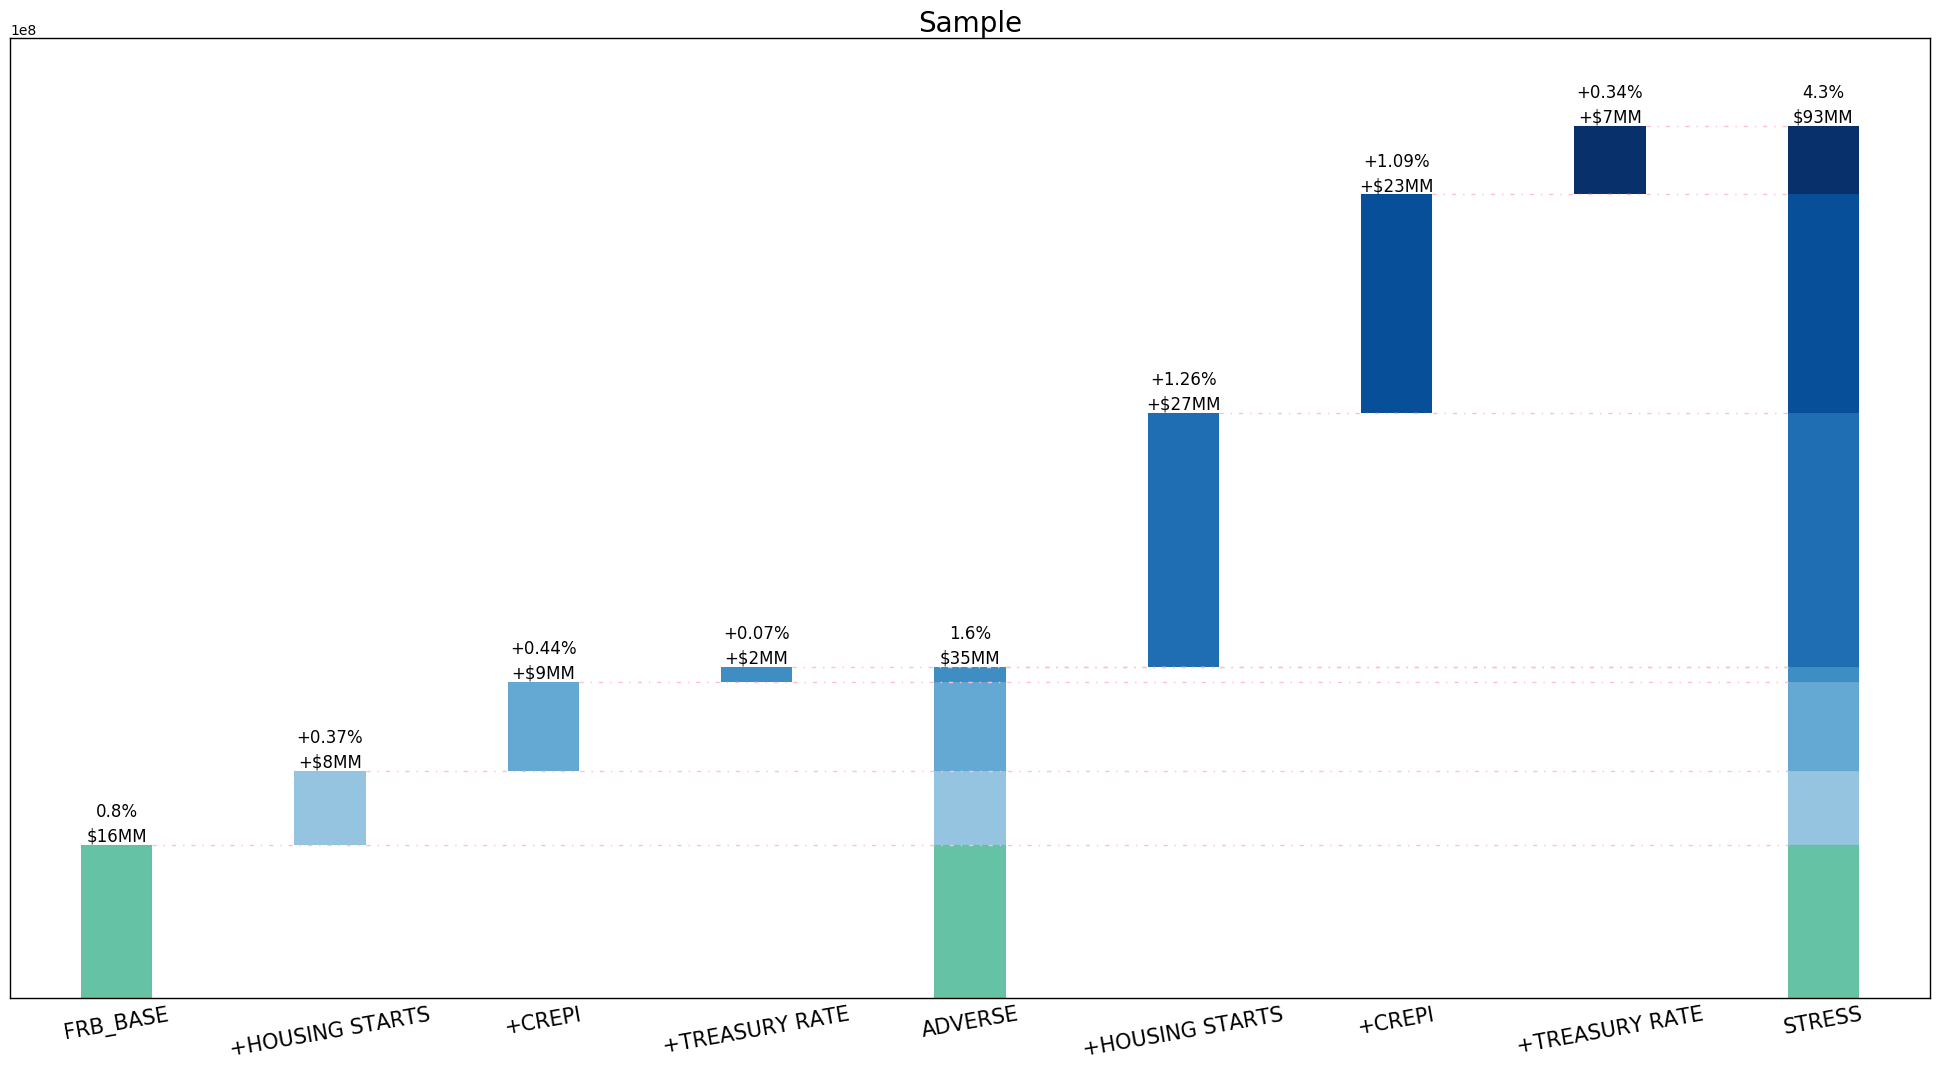

In [12]:
variables_name = ['FRB_BASE','HOUSING STARTS','CREPI','TREASURY RATE','ADVERSE','HOUSING STARTS','CREPI','TREASURY RATE','STRESS']
values = [16374569.374840943,
 24218748.15351149,
 33717149.16350694,
 35306305.06841773,
 35306305.06841773,
 62402147.475668475,
 85724184.22031927,
 93058733.58650766,
 93058733.58650766]

per_values=[0.763113964973029,
 1.128685815902426,
 1.571347483041239,
 1.645408196752005,
 1.645408196752005,
 2.9081856899513503,
 3.9950844580709832,
 4.337149325914016,
 4.337149325914016]
 
aa = triple_sensitivity_plot(names = variables_name,value=values,pct_value= per_values,title = 'Sample',dollar_ind = True )

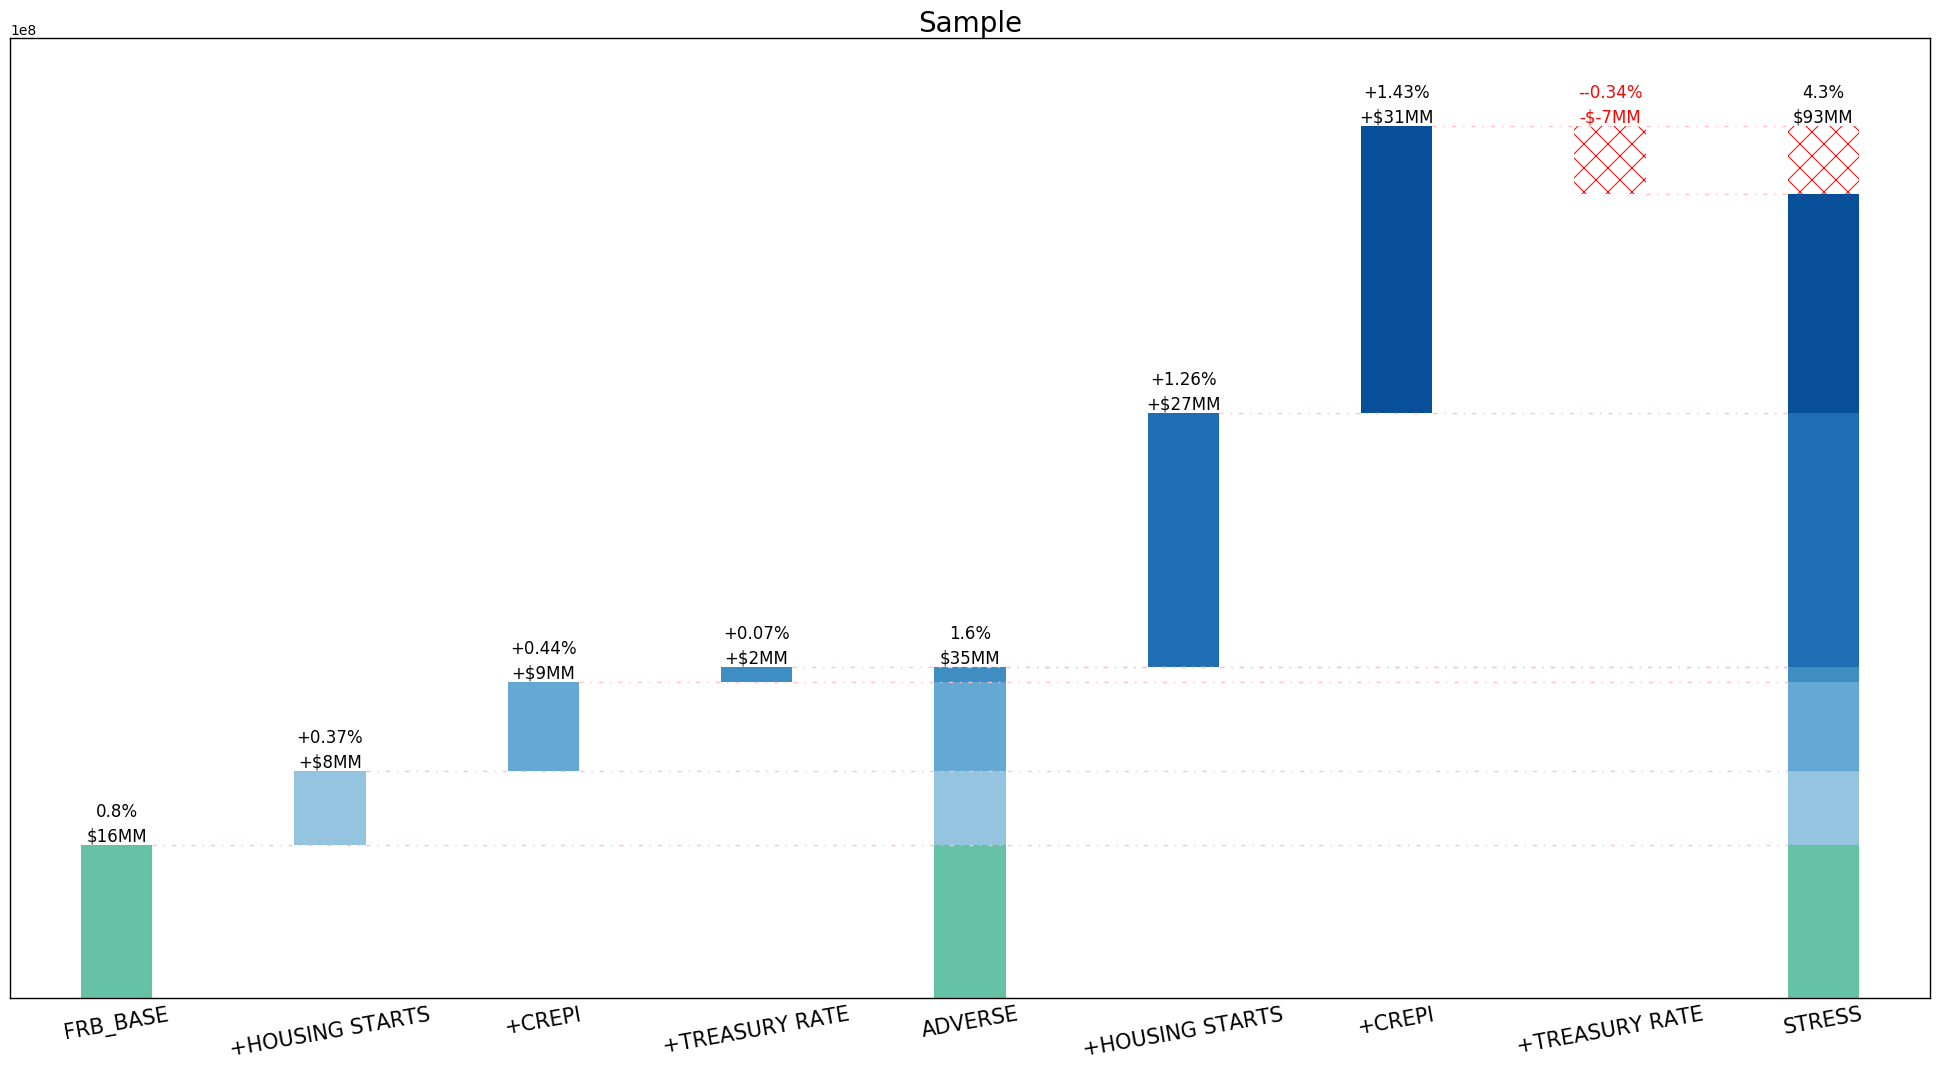

In [13]:
variables_name = ['FRB_BASE','HOUSING STARTS','CREPI','TREASURY RATE','ADVERSE','HOUSING STARTS','CREPI','TREASURY RATE','STRESS']
values = [16374569.374840943,
 24218748.15351149,
 33717149.16350694,
 35306305.06841773,
 35306305.06841773,
 62402147.475668475,93058733.58650766,
 85724184.22031927,
 93058733.58650766]

per_values=[0.763113964973029,
 1.128685815902426,
 1.571347483041239,
 1.645408196752005,
 1.645408196752005,
 2.9081856899513503, 4.337149325914016,
 3.9950844580709832,
 4.337149325914016]
 
aa = triple_sensitivity_plot(names = variables_name,value=values,pct_value= per_values,title = 'Sample',dollar_ind = True )